# Relationship of Femicides and The Economy in Turkey
#### Uğurhan Aksu

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn import linear_model
import matplotlib.dates as mdates

## Table of Contents
1. Femicide Data
2. Interest Rate Data
3. Employment Data
4. Data Aggregation
5. Polynomial Regression Model
6. Conclusion


## 1.Femicide Data

http://anitsayac.com/ website holds a memorial record of women who are murdered after 2008. The website is queried within a loop in order to obtain victim names and murder dates. Duplicate data are removed and the data set is stored within an excel file. Following code block is the only R code in the analysis.

In [ ]:
# R Code, do not run in phython kernel

require("xml2")
require("tidyverse")
require('rvest')
require("stringr")
require("xlsx")
require("readxl")
require("lubridate")
require("dplyr")

#init df
femicide <- data.frame(Name=character(),
                       Date=character(),
                       stringsAsFactors=FALSE)
#parser keys
keys <- paste("Ad Soyad: |Tarih: |İl/ilçe: |Maktülün yaşı: |Neden öldürüldü:  |Kim tarafından öldürüldü:  |Korunma talebi:  |Öldürülme şekli: |Failin durumu: |Kaynak:  ")

consecutive_error = 0
i <- 1
while (consecutive_error < 50 ){
  
  #request parameters
  i <- i+1
  numerator <- paste( paste( rep("0",4-nchar(i)), collapse="" ), i, sep="" )
  an.error.occured <- FALSE
  
  #request
  tryCatch( { page <- read_html(paste("http://anitsayac.com/details.aspx?id=",numerator,sep="")) },
            error = function(e) {an.error.occured <<- TRUE})
  
  #while loop termination
  if(an.error.occured == TRUE){
    consecutive_error <- consecutive_error +1
  }else{
    consecutive_error = 0
  }
  
  #html content
  text <- page %>% html_node("body") %>% html_text()
  text_split <- strsplit(text, split=keys)
  
  #name
  temp1 <- text_split[[1]][2]
  
  #date
  for (row in text_split[[1]]) {
    #accidental age extraction eliminated
    if (nchar(row)>4) {
      if ( !is.na(strtoi(substr(row,1,2))) ) {
        #accidental city code extraction eliminated
        if ( !is.na(strtoi(substr(row,nchar(row),nchar(row)))) ) {
          temp2 <- row
        }
      }
    }
  }
  
  femicide[ nrow(femicide)+1, ] <- c(temp1,temp2)
  
}
#Removing parameters
rm(keys,an.error.occured)
rm(numerator,row,temp1,temp2,text,text_split,page)
rm(i,consecutive_error)

#removing duplicates
femicide <- femicide[!duplicated(femicide[,1]),]

#save excel
write.xlsx(femicide,"/Users/han/Desktop/Ass/Femicide.xlsx")


In [2]:
#read excel
femicide = pd.read_excel( os.path.expanduser("~/Desktop/Ass/") + "femicide.xlsx" )

#sort by date
femicide.sort_values("Date", ascending=True, inplace=True)
femicide.reset_index( drop=True, inplace=True )

#display
femicide.head()

,Date,Name
0,01/01/2009,Melike Tanhal
1,01/01/2009,Hatice Özkaçak
2,01/01/2009,Meryem Tanhal
3,01/01/2010,Mürüvvet Yaradılmış
4,01/01/2010,Zehra Özkan


Date format of the source is inconsistent and in an improper format. Format of the date column is consolidated before converting to pandas date format.

In [3]:
#datetime format
femicide["Date"] = femicide["Date"].str.replace(".","/")
femicide["Date"] = femicide["Date"].str.replace(" ","")
femicide["Date"] = pd.to_datetime(femicide['Date'], format="%d/%m/%Y")
femicide.dtypes

/var/folders/jn/grj6h1j13kq9dtlgt1j43cp40000gn/T/ipykernel_1475/78907412.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  femicide["Date"] = femicide["Date"].str.replace(".","/")


Date    datetime64[ns]
Name            object
dtype: object

By aggregating the data, number of femicides per month is obtained.

In [4]:
#Monthly count
femicide = femicide.groupby( pd.Grouper(key="Date",
                                    axis=0,
                                    freq="1M",
                                    sort=True) ).count()
femicide.reset_index(drop=False, inplace=True)
femicide["Date"] = femicide["Date"].dt.to_period("M")
femicide.head()

,Date,Name
0,2008-01,6
1,2008-02,10
2,2008-03,8
3,2008-04,3
4,2008-05,7


Femicides in Turkey are expressing an increasing trend. The main reasons behind this trend is believed to be decreased household income and corruption in law.

In [5]:
import datetime as dt

dates = ['01/02/1991','01/03/1991','01/04/1991']
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
y = range(len(x)) # many thanks to Kyss Tao for setting me straight here

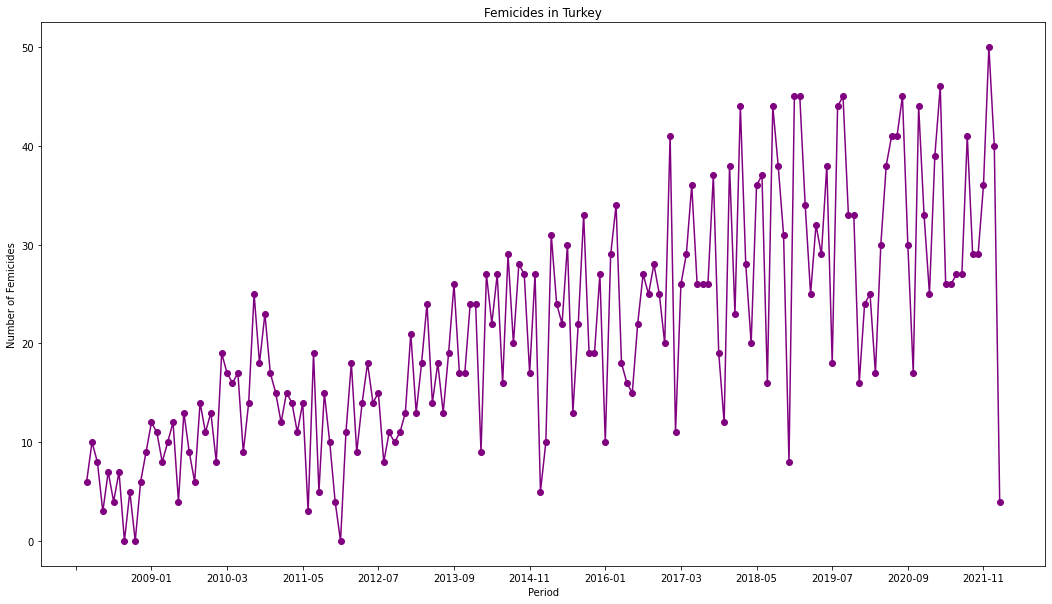

In [6]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(list(map(str, femicide["Date"])),
        femicide["Name"],
        '-o',
        color='purple')
ax.set(xlabel="Period", ylabel="Number of Femicides",
       title="Femicides in Turkey")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

plt.show()


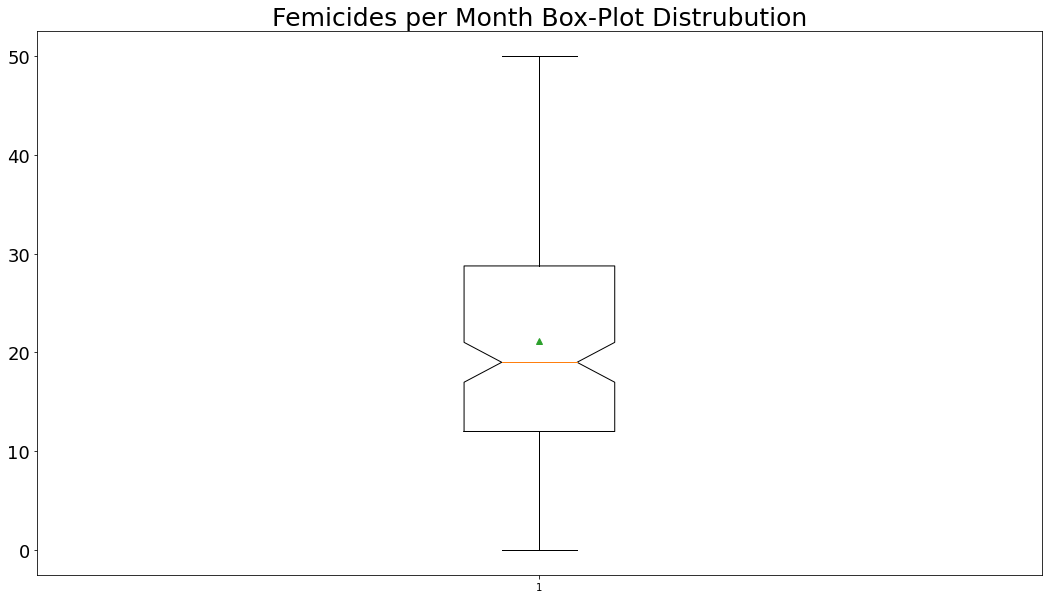

In [7]:
plt.figure( figsize=(18,10) )
plt.boxplot(femicide["Name"],
           notch=True,
           sym="",
           showmeans=True)
plt.title("Femicides per Month Box-Plot Distrubution", fontsize=25)
plt.yticks(fontsize=18)
plt.show()

## 2. Interest Rates Data

Interest rates dictate the economy by mostly determining the amount of money people are posessing. The types of interest rate that are mostly affecting daily lives of the people are; personal (commercial), vehicle and real estate interest rates. This particular effect may have an influence on behavior of men towards women. In order to further investiage, the data is obtained from https://evds2.tcmb.gov.tr/ and cleaned.

In [8]:
#load data
interest = pd.read_excel( os.path.expanduser("~/Desktop/Ass/") + "interest.xlsx" )

#time format
interest["Date"] = pd.to_datetime(interest['Date'], format="%Y/%m")
interest["Date"] = interest["Date"].dt.to_period("M")

interest.head()

,Date,Personal,Vehicle,Estate
0,2008-01,19.8325,16.7925,16.5050
1,2008-02,19.9360,16.9400,16.3860
2,2008-03,20.6275,17.7575,17.2775
3,2008-04,20.9975,18.7625,18.0575
4,2008-05,20.7520,18.7760,17.4520


By observing the graph below, all three types of loan rates are highly correlated. Since the risk decreases with amount of colletarel locked, personal interest rates are always higher.

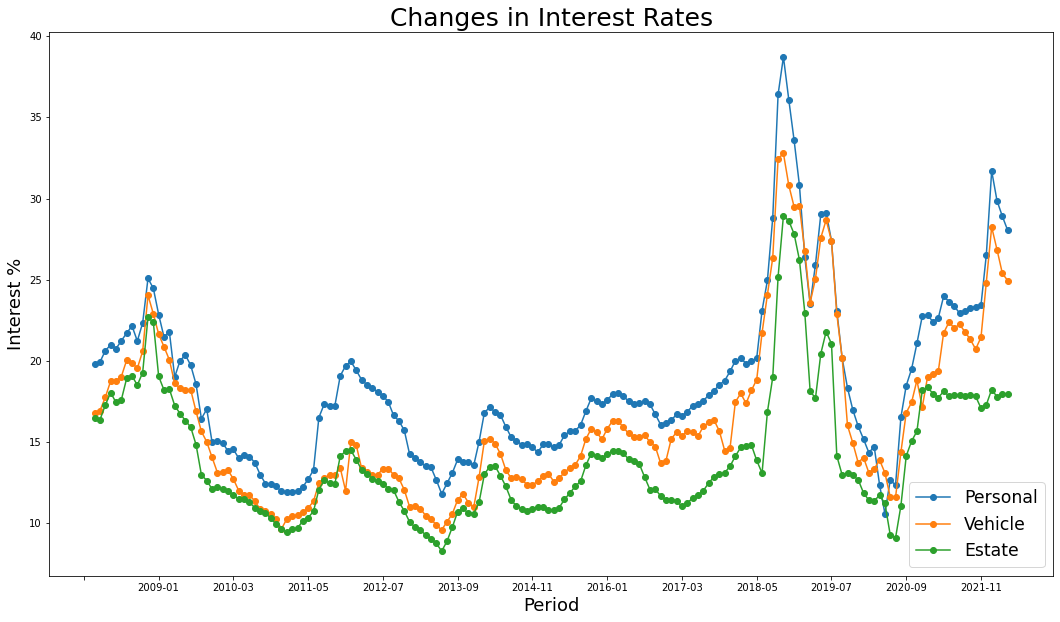

In [9]:
fig, ax = plt.subplots(figsize=(18, 10))

for i in interest.columns.values[1::]:
    ax.plot(list(map(str, interest["Date"])),
            interest[i],
            '-o',
            label=i)

plt.xlabel("Period", fontsize=18)
plt.ylabel("Interest %", fontsize=18)
plt.title("Changes in Interest Rates", fontsize=25)
plt.legend( loc=4, fontsize="xx-large" )

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

plt.show()

## 3. Unemployment Data
Unemployment directly effects a households living conditions and its members morale. Therefore, unemployment status additional types of stress besides financial stress. Depressed morale is very similar to morale of a murderer, therefore it is believed that unemployment status further increase a persons chance of committing murder.

In [10]:
unemp = pd.read_excel( os.path.expanduser("~/Desktop/Ass/") + "unemployment.xlsx" )
unemp["Date"] = pd.to_datetime(unemp['Date'], format="%Y/%m")
unemp["Date"] = unemp["Date"].dt.to_period("M")
unemp.head()

,Date,Unemployment,Employment Percent,Unemployment percent
0,2014-01,2849,42.8,10.5
1,2014-02,2895,43.4,10.5
2,2014-03,2656,45.2,9.4
3,2014-04,2512,45.7,8.8
4,2014-05,2426,46.2,8.4


Unemployment values are represented in thousands. Unemployment percent data field is magnified x75 for visibility.

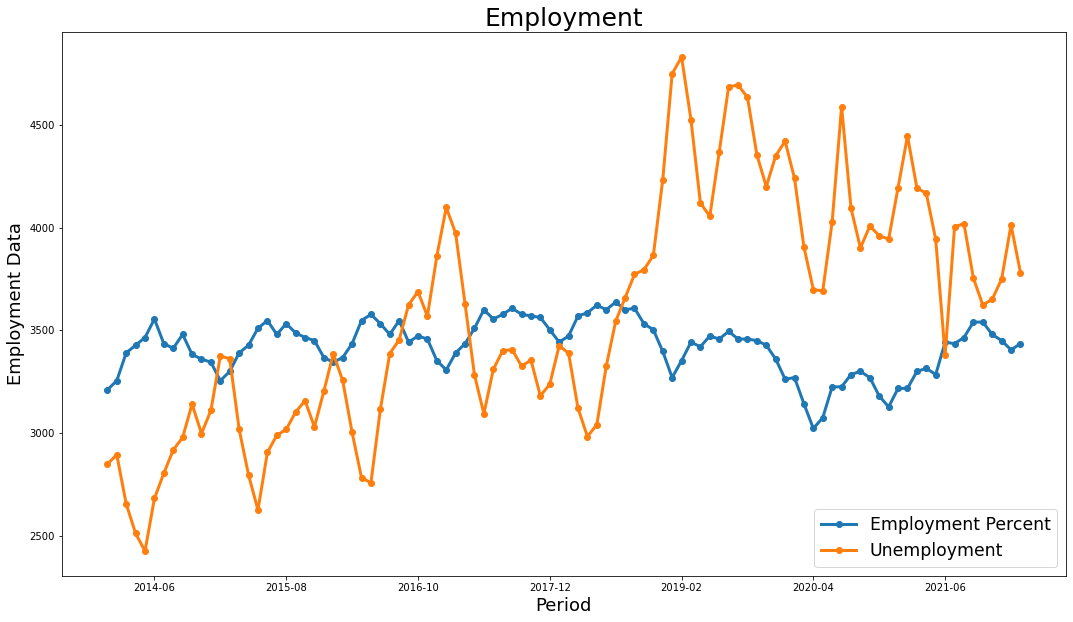

In [22]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(list(map(str, unemp["Date"])),
        unemp["Employment Percent"]*75,
        '-o',
       label="Employment Percent",
       linewidth=3)

ax.plot(list(map(str, unemp["Date"])),
        unemp["Unemployment"],
        '-o',
       label="Unemployment",
       linewidth=3)

plt.legend( loc=4, fontsize="xx-large" )
plt.xlabel("Period", fontsize=18)
plt.ylabel("Employment Data", fontsize=18)
plt.title("Employment", fontsize=25)

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

plt.show()

## 4. Data Aggregation

Individual data frames are aggregated for correlation analysis. Since all of the dataframes have some values of different dates, some of the data is lost.


In [12]:
femicide = femicide.merge(unemp,
                      on="Date",
                      how="inner")

femicide = femicide.merge(interest,
                      on="Date",
                      how="inner")

femicide.set_index("Date", inplace=True)

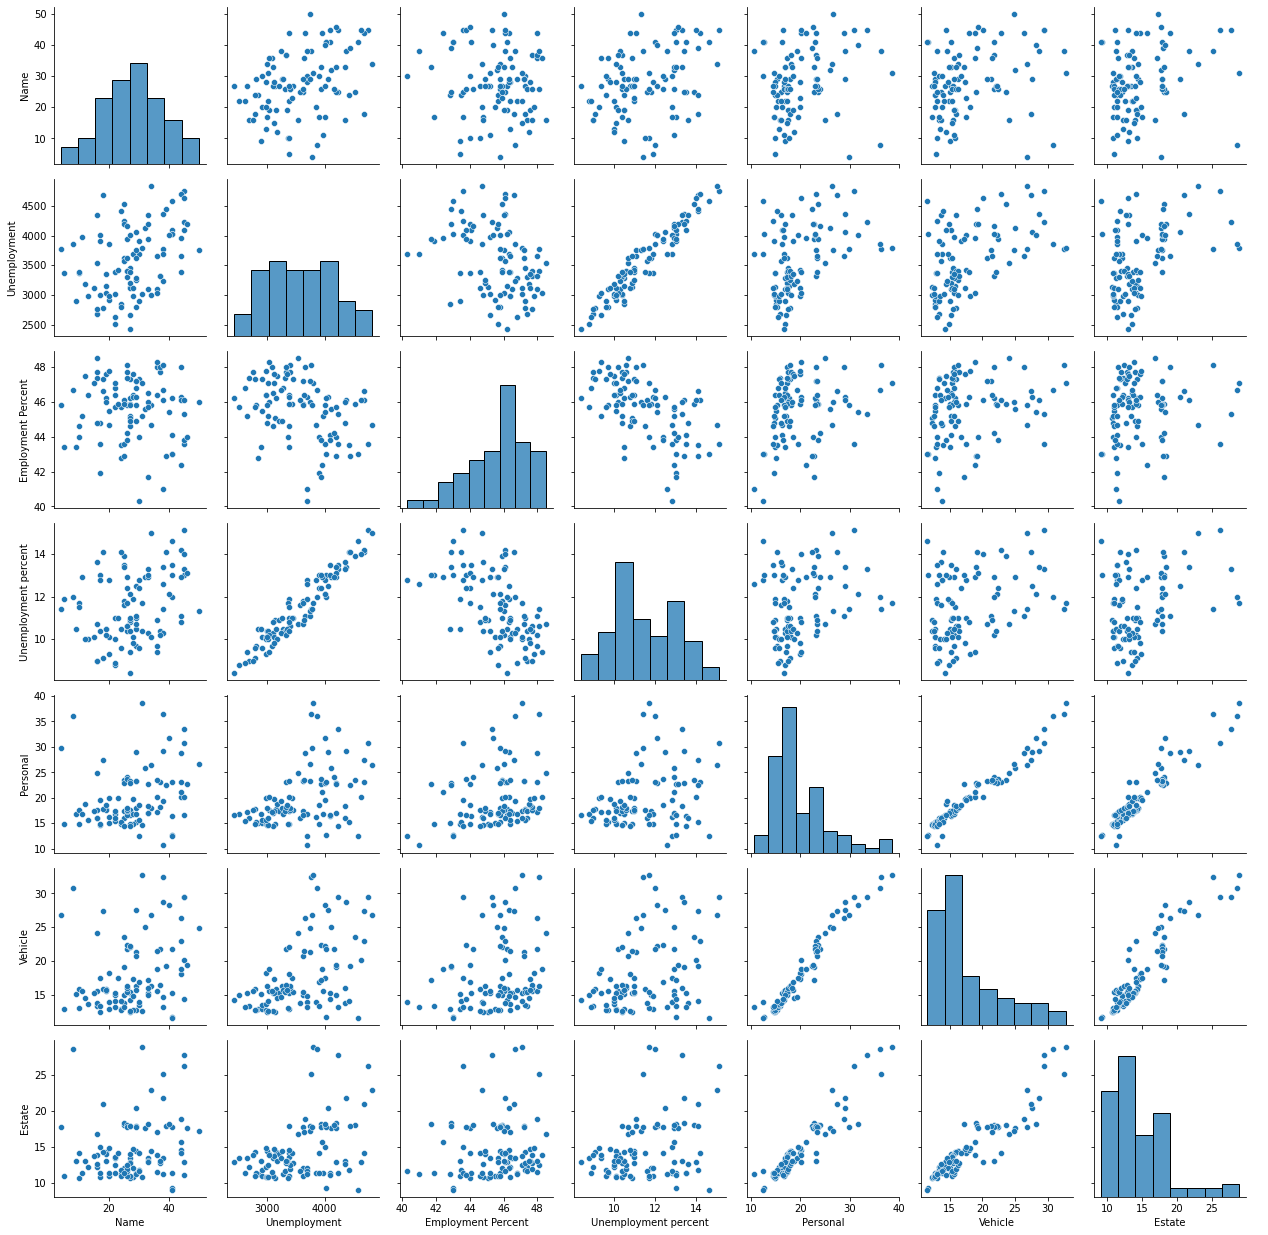

In [13]:
g = sns.PairGrid(femicide)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

By investigating plots above and correlations below, the number of murdered women do not possess a significant correlation with interest and unemployment data.

In [14]:
femicide.corr()

,Name,Unemployment,Employment Percent,Unemployment percent,Personal,Vehicle,Estate
Name,1.000000,0.377465,-0.074873,0.315460,0.237095,0.276042,0.199728
Unemployment,0.377465,1.000000,-0.359817,0.960301,0.426624,0.497600,0.430547
Employment Percent,-0.074873,-0.359817,1.000000,-0.567213,0.254593,0.221535,0.119210
Unemployment percent,0.315460,0.960301,-0.567213,1.000000,0.270572,0.341859,0.316661
Personal,0.237095,0.426624,0.254593,0.270572,1.000000,0.976032,0.941433
Vehicle,0.276042,0.497600,0.221535,0.341859,0.976032,1.000000,0.923495
Estate,0.199728,0.430547,0.119210,0.316661,0.941433,0.923495,1.000000


To analyze further, change value of each data field is obtained by substracting the values at t+1 by t. Naturally, first data point is lost.

In [ ]:
changes = femicide.copy()

for i in range( changes.shape[0]-1 ):
    changes["Name"][i+1] = (femicide["Name"][i+1]-femicide["Name"][i])
    changes["Unemployment"][i+1] = (femicide["Unemployment"][i+1]-femicide["Unemployment"][i])
    changes["Employment Percent"][i+1] = (femicide["Employment Percent"][i+1]-femicide["Employment Percent"][i])
    changes["Unemployment percent"][i+1] = (femicide["Unemployment percent"][i+1]-femicide["Unemployment percent"][i])
    changes["Personal"][i+1] = (femicide["Personal"][i+1]-femicide["Personal"][i])
    changes["Vehicle"][i+1] = (femicide["Vehicle"][i+1]-femicide["Vehicle"][i])
    changes["Estate"][i+1] = (femicide["Estate"][i+1]-femicide["Estate"][i])
    
changes = changes.iloc[1:,:]

In [16]:
changes.corr()

,Name,Unemployment,Employment Percent,Unemployment percent,Personal,Vehicle,Estate
Name,1.000000,0.016491,-0.106151,0.028205,-0.013159,0.020996,-0.159862
Unemployment,0.016491,1.000000,-0.389747,0.966591,-0.000917,0.125552,-0.016099
Employment Percent,-0.106151,-0.389747,1.000000,-0.603833,0.031728,-0.070160,-0.037969
Unemployment percent,0.028205,0.966591,-0.603833,1.000000,-0.012342,0.122255,-0.002240
Personal,-0.013159,-0.000917,0.031728,-0.012342,1.000000,0.826701,0.736373
Vehicle,0.020996,0.125552,-0.070160,0.122255,0.826701,1.000000,0.687908
Estate,-0.159862,-0.016099,-0.037969,-0.002240,0.736373,0.687908,1.000000


In [17]:
cor = list(femicide.corr()["Name"][femicide.corr()["Name"] > 0.2][1::].index.values)
print("Columns that express more than 0.2 correlation: ",cor)

Columns that express more than 0.2 correlation:  ['Unemployment', 'Unemployment percent', 'Personal', 'Vehicle']


By looking at the correlation matrix, the change data is posessing much less correlation. Therefore, correlation among the changes will not be further pursued within the analysis.

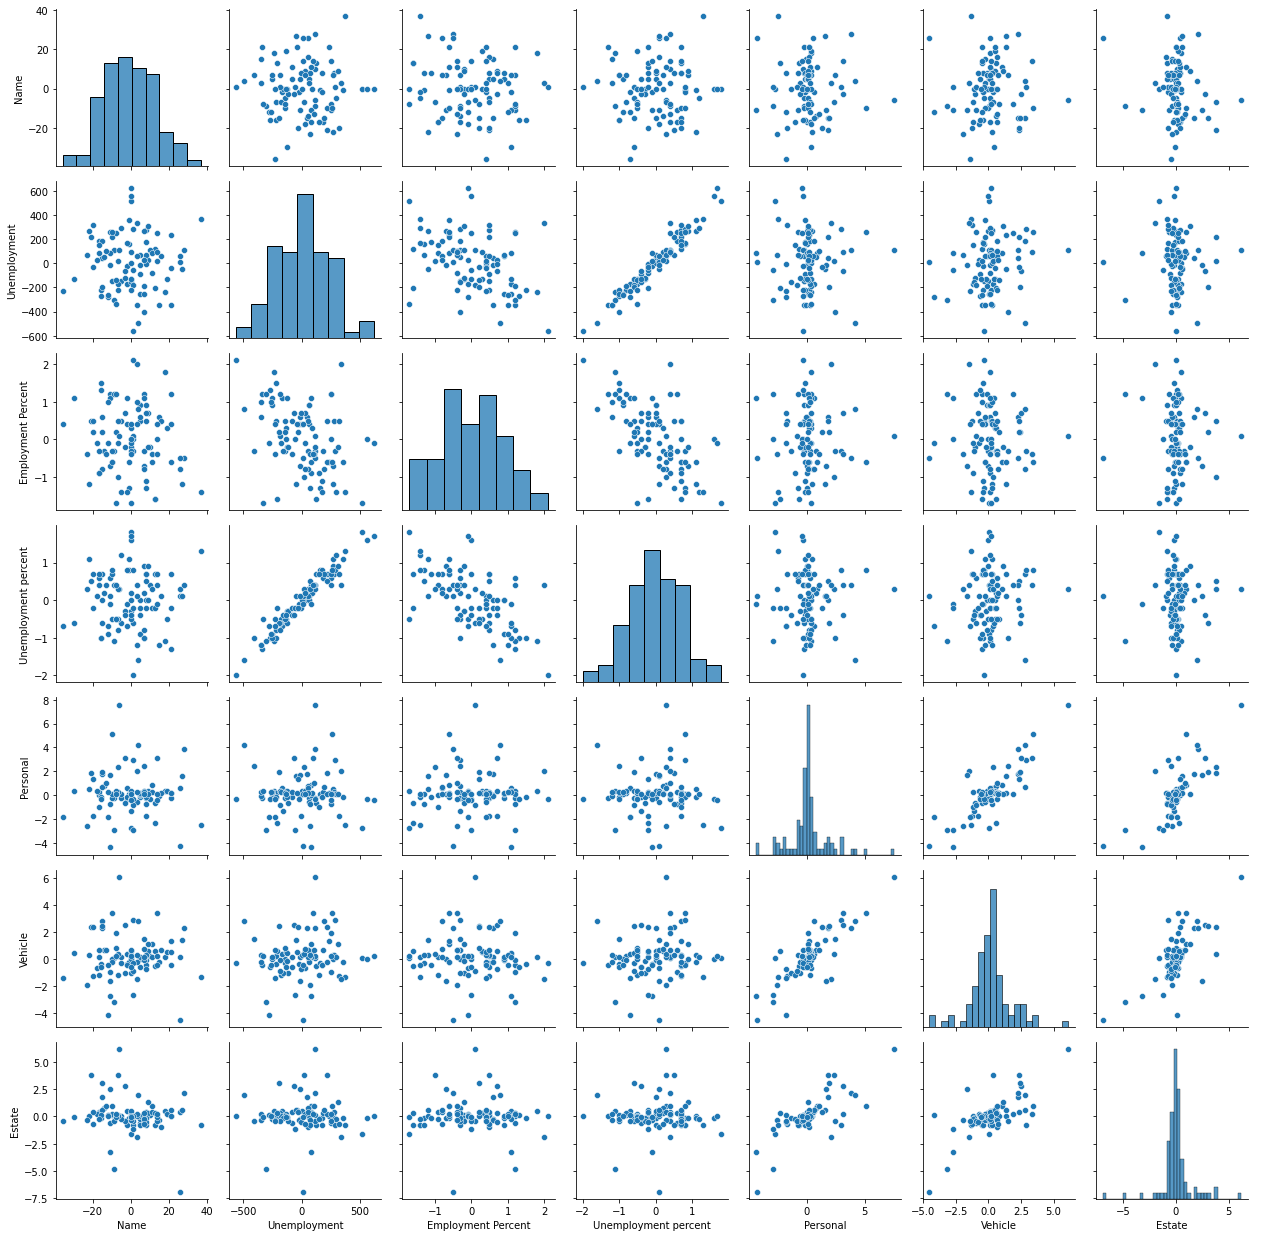

In [18]:
g = sns.PairGrid(changes)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## 5. Polynomial Regression Model

Changes in Employment Percent, Unemployment percent, Personal data fields are found to have insignificant correlation with changes in number of femicides in Turkey. Since the relationship was not linear, a polynomial regression model is utilized in order to test predictive capabilities of such data. The data is divided into model training and testing sets.

In [19]:
#Unemployment and its % is almost perfectly correlated, thus removed
cor = cor[1:]

#test-train split
tts=0.75

# dependent, independent variables
x_train = np.asanyarray( femicide[cor][:int(np.ceil(femicide.shape[0]*tts))] )
y_train = np.asanyarray( femicide["Name"][:int(np.ceil(femicide.shape[0]*tts))] )
x_test = np.asanyarray( femicide[cor][int(np.floor(femicide.shape[0]*tts)):] )
y_test = np.asanyarray( femicide["Name"][int(np.floor(femicide.shape[0]*tts)):] )

print("X train shape:",x_train.shape)
print("Y train shape:",y_train.shape)
print("X test shape:",x_test.shape)
print("Y test shape:",y_test.shape)


X train shape: (74, 3)
Y train shape: (74,)
X test shape: (25, 3)
Y test shape: (25,)


Optimal degree for the polynomial model is evaluated by compating MSE values of the models that are having a degree up to fifty.

Best n:  1


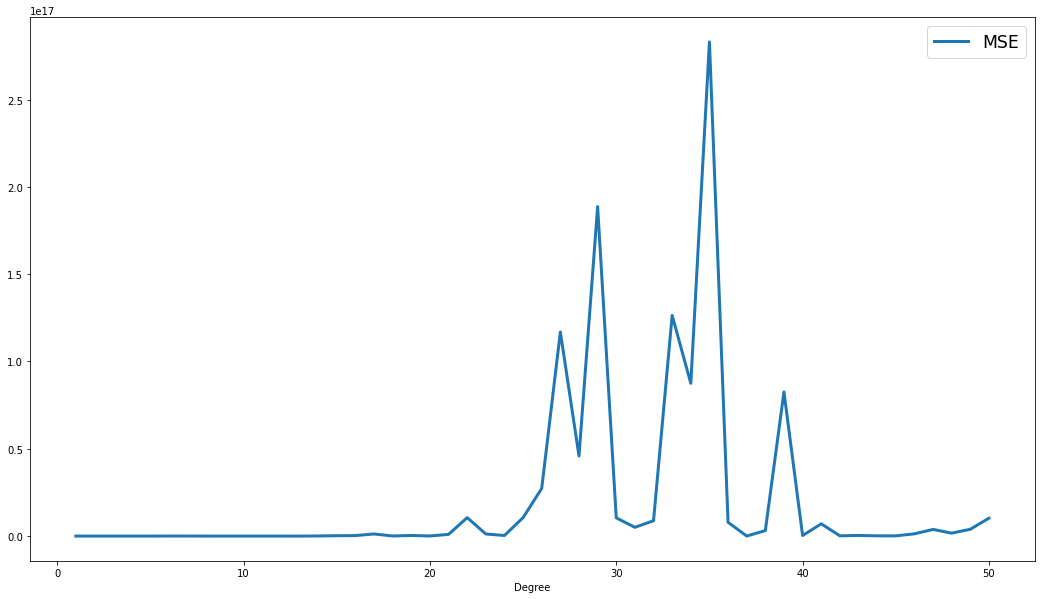

In [20]:
#total error lists
mse = []
n_list = []

#evaluation for different polinomial degrees
n_max=50
for n in range (1, n_max+1):
    poly = PolynomialFeatures(degree=n)
    x_train_p = poly.fit_transform(x_train)
    x_test_p = poly.fit_transform(x_test)
    lr = linear_model.LinearRegression()
    lr.fit( x_train_p, y_train )
    test_pred = lr.predict( x_test_p )
    mse_temp = metrics.mean_squared_error( y_test, test_pred )
    n_list.append( n )
    mse.append( mse_temp )

#error dataframe 
n_dict = {
    "Degree" : n_list,
    "MSE": mse
}
n_df = pd.DataFrame.from_dict(n_dict)
n_df.plot(x="Degree",
          y="MSE",
          figsize=(18,10),
         linewidth=3)
plt.legend(loc=1,fontsize="xx-large")

#model with best configuration
n_best = n_df[ n_df["MSE"] == n_df["MSE"].min() ]["Degree"].values
print( "Best n: ", int(n_best) )
poly = PolynomialFeatures(degree=int(n_best))
x_train_p = poly.fit_transform(x_train)
lr = linear_model.LinearRegression()
lr.fit( x_train_p, y_train )
prediction = lr.predict( x_train_p )



Although the visibly observed relationship was not linear, the least MSE yielded with a linear model. Predictions of the model is generated and compared with the actual results. Although predictions seem fairly reasonable, r2 score of the model is too low to be a successfull candidate. Additionally, having some intercept coefficients very close to zero further invalidates the models adaquecy.

Regression intercept:  13.767049154930405
Regression coefficents:  [ 0.          0.31758788 -1.12840304  1.76366871]
Reg score:  0.09850009789564462


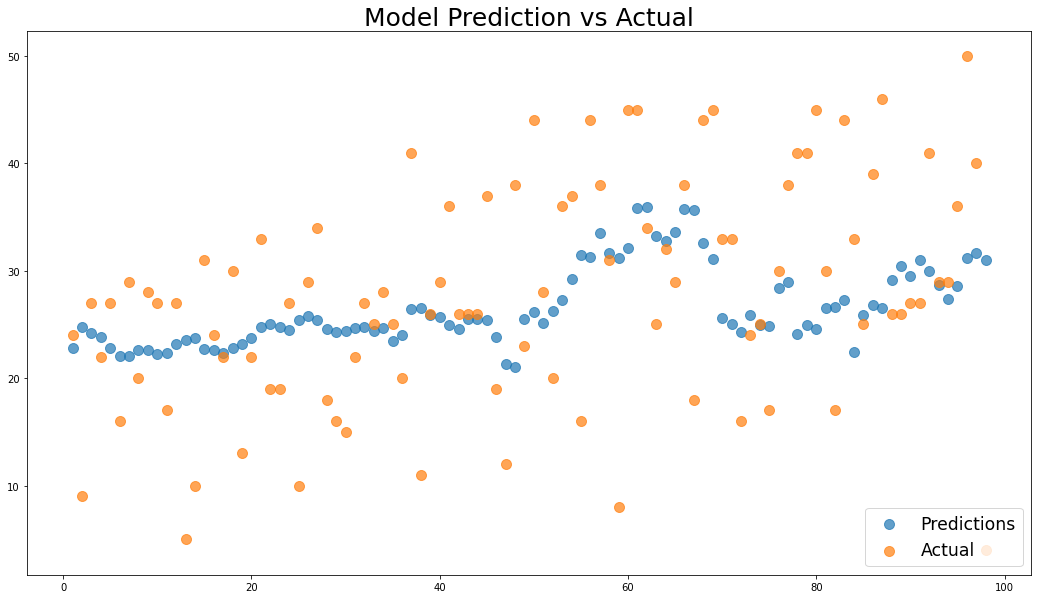

In [21]:
n=1
poly = PolynomialFeatures(degree=n)
x_train_p = poly.fit_transform(x_train)
x_test_p = poly.fit_transform(x_test)
lr = linear_model.LinearRegression()
lr.fit( x_train_p, y_train )
test_pred = lr.predict( poly.fit_transform(femicide[cor]) )

#regression params
print("Regression intercept: ", lr.intercept_)
print("Regression coefficents: ", lr.coef_)
print("Reg score: ",lr.score( poly.fit_transform(femicide[cor]) , femicide["Name"] ))

plt.figure( figsize=(18,10) )
plt.scatter(list(np.linspace(1,len(test_pred),len(test_pred))),
           test_pred,
           label="Predictions",
           s=100,
           alpha=0.7)
plt.scatter(list(np.linspace(1,len(test_pred),len(test_pred))),
           femicide["Name"],
           label="Actual",
           s=100,
           alpha=0.7)

plt.legend( loc=4, fontsize="xx-large" )
plt.title("Model Prediction vs Actual", fontsize=25)

plt.show()

## 6. Conclusion

Personal (commercial) interest rate and employment throughput is found to be insignificantly correlated with
number of femicides in Turkey. Although they are good candidate data fields to include in a such model, the inadequacy of the polynomial regression model proves that those data fields are not solely enough to make a succesfull estimation. For an improved prediction accuracy, those data fields must be assisted with additional information. And most probably different data transformations and prediction models should yield better results.